In [1]:
#Importing modules
import re
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import glob
import warnings 
import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

warnings.filterwarnings("ignore")



2022-04-27 22:52:20.204576: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 22:52:20.204604: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


No GPU found


2022-04-27 22:52:23.358424: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 22:52:23.359704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-27 22:52:23.359755: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-27 22:52:23.359780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Asteria): /proc/driver/nvidia/version does not exist


In [2]:
#DATA INFORMATION AND PATH

# Root directory of the procondect
BASE_DIR = os.path.abspath("./")

# Data directory of the project
DATA_DIR =  os.path.join(BASE_DIR, "Dataset/data-task1")

# dataset respective directory
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
VAL_DIR = os.path.join(DATA_DIR, "val")

BATCH_SIZE = 30

# Use small images for faster training. Set the limits of the small side
# the large side, and that determines the image shape.
IMAGE_MIN_DIM = 224
IMAGE_MAX_DIM = 224

#EPOCHS FOR MODEL
EPOCHS = 30
# Summary of Data information
#TODO TASK: 'Put summary of data information here later' .time:2022-04-22  13:43:01

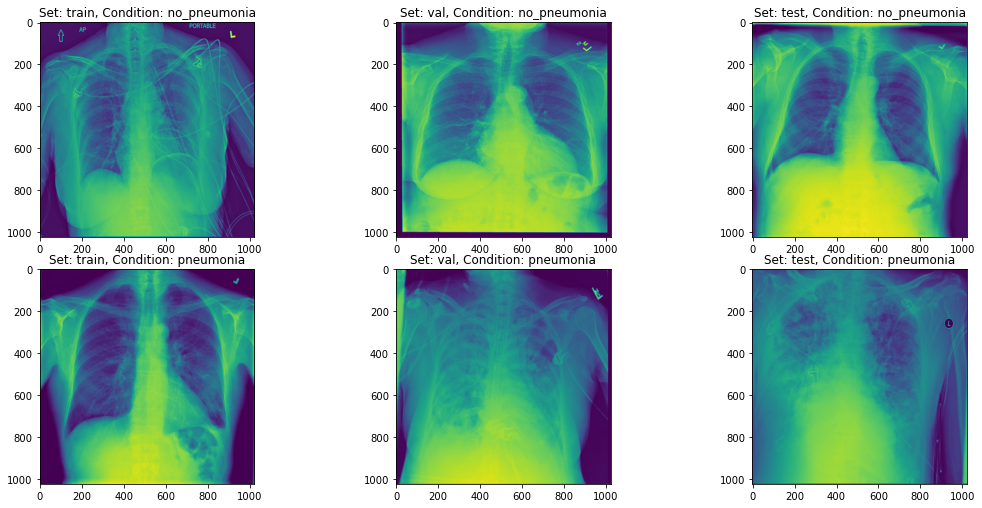

In [3]:
#setting plot parameters for plt
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

#plotting random non-pneumonia and pneumonia images from our train, test, and val to see how much different they look to our eye
for i, dir_ in enumerate(glob.glob(f'{DATA_DIR}/*')):
    ax[i].imshow(plt.imread(dir_ + '/no_pneumonia/' +next(os.walk(dir_+'/no_pneumonia/'))[2][0]))
    ax[i].set_title(f'Set: {dir_.split("/")[-1]}, Condition: no_pneumonia')

    ax[i+3].imshow(plt.imread(dir_ + '/pneumonia/' +next(os.walk(dir_+'/pneumonia/'))[2][0]))
    ax[i+3].set_title(f'Set: {dir_.split("/")[-1]}, Condition: pneumonia')

train Dataset 
 Non-pneumonia images: 2358 
 pneumonia images: 642 



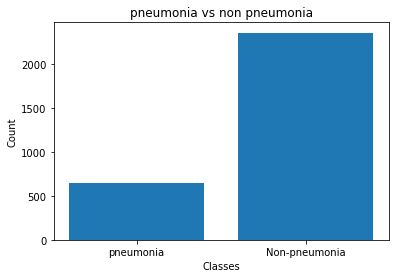

val Dataset 
 Non-pneumonia images: 390 
 pneumonia images: 110 



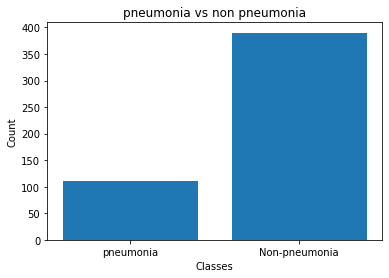

test Dataset 
 Non-pneumonia images: 395 
 pneumonia images: 105 



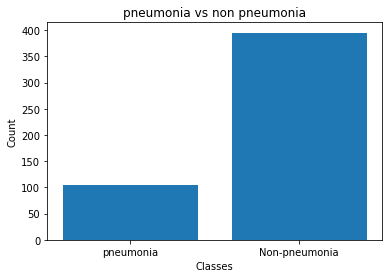

In [4]:
#parsing and storing datasets into variable
non_pneumonia_train = glob.glob(f'{TRAIN_DIR}/no_pneumonia/*.png')
pneumonia_train = glob.glob(f'{TRAIN_DIR}/no_pneumonia/*.png')


#Basic EDA -Descriptive
for i in glob.glob(f'{DATA_DIR}/*'):
    non_pneumonia_images_count = len(glob.glob(i+'/no_pneumonia/*.png'))
    pneumonia_images_count = len(glob.glob(i+'/pneumonia/*.png'))
    print(f'{i.split("/")[-1]} Dataset \n Non-pneumonia images: {non_pneumonia_images_count} \n pneumonia images: {pneumonia_images_count} \n')

    x = ['pneumonia', 'Non-pneumonia']
    y = [pneumonia_images_count, non_pneumonia_images_count]
    plt.bar(x, y)
    plt.title('pneumonia vs non pneumonia')
    plt.ylabel('Count')
    plt.xlabel('Classes')
    plt.show()


In [5]:
#DATA AUGMENTATION
'''
AUGMENTATION IS A PRACTIVE THAT ALLOWS US TO INCREASE THE SIZE OF HTE TRAINING SET.AUGMENTING THE TRAINING EXAMPLES ALLOWS THE MOD
MODEL TO SEE OUR DATASET IMAGES IN A MORE DIVERSE WAYS. AUGMENTATION ALSO ALLOWS US TO CREATE A LARGER DATASET FOR OUR MODEL TO 
TRAIN ON. 
'''
train_data_gen = ImageDataGenerator(
    rescale = 1/255,
    shear_range=10,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5,2.0],
    width_shift_range = 0.2,
    rotation_range=20,
    fill_mode = 'nearest',
    validation_split=0.2
)

val_test_data_gen = ImageDataGenerator(
    rescale = 1/255,
)


In [6]:
train_images = train_data_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_MIN_DIM, IMAGE_MAX_DIM),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    # shuffle=True,
    color_mode="grayscale"
)

test_images = val_test_data_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_MIN_DIM, IMAGE_MAX_DIM),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    # shuffle=True,
    color_mode="grayscale"
)

validation_images = val_test_data_gen.flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_MIN_DIM, IMAGE_MAX_DIM),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    # shuffle=True,
    color_mode="grayscale"
)

#getting X_train and y_train images for use later on
train_images.reset()
X_train, y_train = next(train_images)
print('getting train images')
for i in tqdm.tqdm(range(int(train_images.n/BATCH_SIZE)-1)): #1st batch is already fetched before the for loop.
  img, label = next(train_images)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

#getting X_test and y_test images for use later on
train_images.reset()
X_test, y_test = next(test_images)
print('getting test images')
for i in tqdm.tqdm(range(int(test_images.n/BATCH_SIZE)-1)): #1st batch is already fetched before the for loop.
  img, label = next(test_images)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)


Found 3000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


 60%|█████▉    | 59/99 [01:21<01:09,  1.74s/it]

In [ ]:
inputs = Input(shape=(IMAGE_MIN_DIM, IMAGE_MAX_DIM, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='softmax')(x)

# METRICS = [
#       tf.keras.metrics.TruePositives(name='tp'),
#       tf.keras.metrics.FalsePositives(name='fp'),
#       tf.keras.metrics.TrueNegatives(name='tn'),
#       tf.keras.metrics.FalseNegatives(name='fn'), 
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),
#       tf.keras.metrics.AUC(name='auc'),
# ]

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()
# plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)


# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# %%time
history1 = model.fit(
    train_images,
    epochs = EPOCHS,
    steps_per_epoch = train_images.samples // BATCH_SIZE,
    validation_data = validation_images,
    # validation_steps = test_images.samples // BATCH_SIZE,
    callbacks = [checkpoint, lr_reducer, early_stopping]
)

In [ ]:
img_width = 500
img_height = 500
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.summary()
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

weights = compute_class_weight('balanced', np.unique(train_images.classes), train_images.classes)
cw = dict(zip( np.unique(train_images.classes), weights))
print(cw)

cnn.fit(
    train_images,
    epochs=3, 
    validation_data=validation_images, 
    class_weight=cw, 
    callbacks=callbacks_list
    )

In [ ]:
#EVALUATING CNN MODEL

score = model.evaluate(train_images)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])


plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF MODEL')

plt.subplot(2, 2, 1)
plt.plot(history1.history['loss'], label='Loss')
plt.plot(history1.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history1.history['accuracy'], label='Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
preds = model.predict(test_images)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))

In [ ]:
# VGG Model

In [ ]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

#fitting model
history_vgg = model2.fit(train_images,epochs=30, 
                    validation_data=validation_images,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=BATCH_SIZE)

ResNet50V2

In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model3 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# to avoid overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)

# Compiling the model
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

#Fitting Model
history3 = model3.fit(train_images,epochs=30,
                    validation_data=validation_images,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=BATCH_SIZE)

In [ ]:
# Store the data in X_train, y_train variables by iterating over the batches
train_images.reset()
X_train, y_train = next(train_images)
for i in tqdm.tqdm(range(int(len(train_images)/BATCH_SIZE)-1)): #1st batch is already fetched before the for loop.
  img, label = next(train_images)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

In [6]:
x_train_new = []
y_train_new = []
for x, y in train_images:
    x_train_new.append(x)
    y_train_new.append(y)
print(len(x_train_new))

In [ ]:
test_images.reset()
X_test, y_test = next(test_images)
for i in tqdm.tqdm(range(int(len(test_images)/BATCH_SIZE)-1)): #1st batch is already fetched before the for loop.
  img, label = next(test_images)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

KNN CLASSIFIER -- BASIC

In [6]:
knn  = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_images)

predictions = knn.predict(X_test)
score = accuracy_score(y_test, predictions)
print("KNN accuracy:",score)

TypeError: fit() missing 1 required positional argument: 'y'